In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Prepare the Data**

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load your data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/LSTM/ETTh1.csv')

features = data[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']].values
temperature = data['OT'].values

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_temperature = MinMaxScaler(feature_range=(0, 1))

features_normalized = scaler_features.fit_transform(features)
# temperature_normalized = scaler_temperature.fit_transform(temperature.reshape(-1, 1))
temperature_normalized = temperature.reshape(-1, 1)

# Create sequences
def create_sequences(features, target, seq_length):
    sequences = []
    targets = []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        targets.append(target[i:i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 24  # Sequence length
X, y = create_sequences(features_normalized, temperature_normalized, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.75 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

**Define Model**

In [4]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self,
                 device,
                 input_size=6,
                 hidden_size=64,
                 num_layers=3,
                 output_size=1,
                 dropout=0,
                 seq_len=10,
                 pred_len=10,
                 ):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_size = input_size
        self.device = device
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.batch_first = True
        self.bidirectional = False
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, dropout=self.dropout,
                            batch_first=self.batch_first, bidirectional=self.bidirectional)

        self.reg = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size),
                                 nn.Tanh(),
                                 nn.Linear(self.hidden_size, self.output_size),
                                 )
        self.Linear = nn.Linear(self.seq_len, self.pred_len)

    def initial_hidden_state(self, batch_size):
        num_directions = 2 if self.bidirectional else 1
        h_0 = torch.randn(self.num_layers * num_directions, batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_layers * num_directions, batch_size, self.hidden_size).to(self.device)
        return (h_0, c_0)

    def forward(self, x):
        hidden_state = self.initial_hidden_state(x.size(0))
        lstm_out, hidden = self.lstm(x, hidden_state)
        outputs = self.reg(lstm_out)
        outputs = self.Linear(outputs.permute(0,2,1)).permute(0,2,1)
        return outputs

Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", end = ' ')
print('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM(input_size=6,
             hidden_size=64,
             num_layers=2,
             output_size=1,
             dropout=0,
             seq_len= seq_length,
             pred_len= seq_length,
             device=Device).to(torch.device(Device))

Device: cuda


**Train Model**

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay= 1e-5)

num_epochs = 200
training_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(model.device), y_batch.to(model.device)
        optimizer.zero_grad()
        outputs = model.forward(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_epoch_loss = epoch_loss / len(train_loader)
    training_losses.append(average_epoch_loss)
    if ((epoch+1) % 10 == 0):
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_epoch_loss}', end = ' ')

    model.eval()
    with torch.no_grad():
        epoch_loss = 0
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(model.device), y_batch.to(model.device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

    average_val_loss = epoch_loss / len(val_loader)
    val_losses.append(average_val_loss)
    if ((epoch+1) % 10 == 0):
      print(f'Val Loss: {average_val_loss}')

Epoch 10/200, Train Loss: 22.473806180206 Val Loss: 19.56086959313909
Epoch 20/200, Train Loss: 16.193318570361416 Val Loss: 20.75248125058795
Epoch 30/200, Train Loss: 5.1844956699539635 Val Loss: 5.155617390203913
Epoch 40/200, Train Loss: 7.645978551869299 Val Loss: 8.023908343883829
Epoch 50/200, Train Loss: 8.604784402192807 Val Loss: 4.092971823631077
Epoch 60/200, Train Loss: 2.6708057154627407 Val Loss: 2.9564928844434406
Epoch 70/200, Train Loss: 2.4514424835934356 Val Loss: 2.7591324596230042
Epoch 80/200, Train Loss: 2.2106608102718988 Val Loss: 2.5040798471608294
Epoch 90/200, Train Loss: 3.8428122223007914 Val Loss: 2.8942621377629973
Epoch 100/200, Train Loss: 1.8059149402029373 Val Loss: 2.1310932745627307
Epoch 110/200, Train Loss: 1.7194594407782835 Val Loss: 2.072010081842405
Epoch 120/200, Train Loss: 1.6147351744128209 Val Loss: 1.9474879612616443
Epoch 130/200, Train Loss: 1.4496591164200914 Val Loss: 1.652025194343077
Epoch 140/200, Train Loss: 1.29992679754893 Va

**Plot training stats**

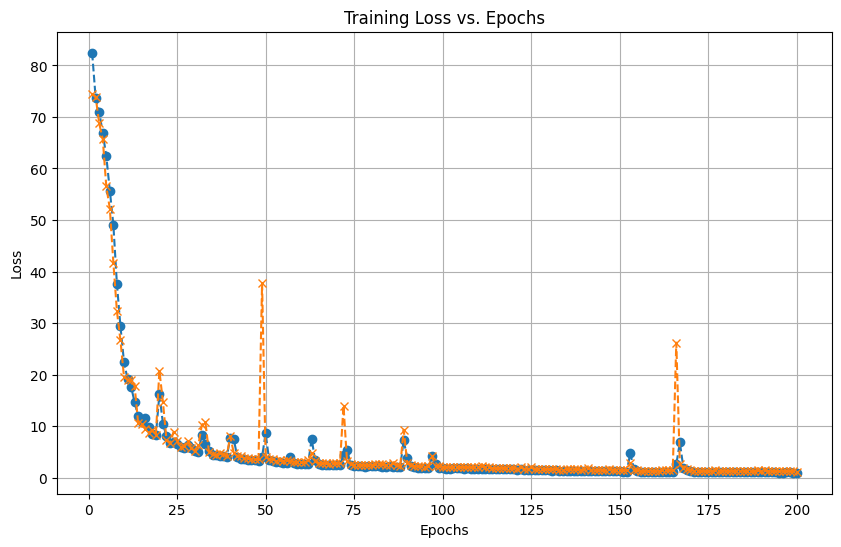

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, marker='o', linestyle='--')
plt.plot(range(1, num_epochs + 1), val_losses, marker='x', linestyle='--')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

**Evaluate the model**

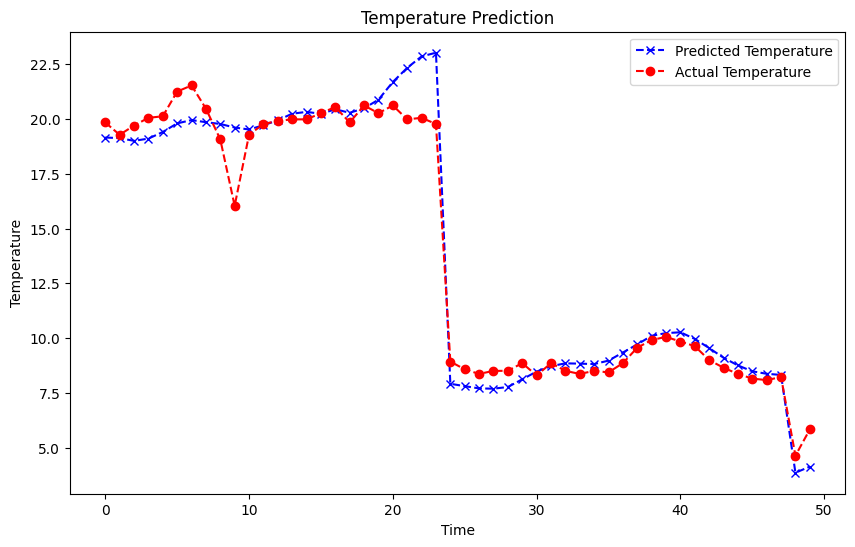

In [7]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(model.device)
        outputs = model(X_batch)
        predictions.append(list(outputs.cpu().numpy().flatten()))
        actuals.append(list(y_batch.numpy().flatten()))
    predictions = [
    x
    for xs in predictions
    for x in xs]
    actuals = [
    x
    for xs in actuals
    for x in xs]

# # Inverse transform to get actual temperature values
# predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))
plt.figure(figsize=(10,6))
plt.plot(predictions[0:50], color='blue', marker='x', linestyle='--', label='Predicted Temperature')
plt.plot(actuals[0:50], color='red', marker='o', linestyle='--', label='Actual Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

**Make Predictions**

In [125]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(model.device)
        outputs = model(X_batch.unsqueeze(-1))
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.numpy())

# Inverse transform to get actual temperature values
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(actuals.flatten(), color='blue', label='Actual Temperature')
plt.plot(predictions.flatten(), color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead